### Read and save assays from PDBBind v2020

In [24]:
import pandas as pd
import numpy as np

# Read the file and process each line
file_path = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/index/INDEX_general_PL.2020"
column_names = ["PDB code", "resolution", "release year", "binding data", "reference", "ligand name"]
data = []

with open(file_path, 'r') as file:
    for line in file:
        line = line.split(";")[0]  # Ignore content after ";"
        if not line.startswith("#"):  # Skip lines starting with '#'
            parts = line.split()
            pdb_code = parts[0]
            resolution = parts[1]
            release_year = parts[2]
            binding_data = " ".join(parts[3:4])
            reference = " ".join(parts[5:6])
            ligand_name = " ".join(parts[6:])
            data.append([pdb_code, resolution, release_year, binding_data, reference, ligand_name])

# Create DataFrame
df = pd.DataFrame(data, columns=column_names)

# Split the binding data into three columns
df["assay"] = df["binding data"].str.extract(r'(\w+)(?=[<>]=?|<|>|=|~)')
df["sign"] = df["binding data"].str.extract(r'([<>]=?|<|>|=|~)')
df["value"] = df["binding data"].str.extract(r'(?:[<>]=?|<|>|=|~)(\d*\.\d+|\d+\.\d*|\d+)')
df["units"] = df["binding data"].str.extract(r'(?:\d*\.\d+|\d+\.\d*|\d+)(\w+)$')
df_ic50 = df[df["assay"]=='IC50']
print(df_ic50)

# If the value is None, assign 0 to it
df["value"] = df["value"].fillna(0)

# Normalize the values in the "value" column
df["assay"] = "p" + df["assay"]  # Add "p" in front of all assay strings
def normalize_value(row):
    value = float(row["value"])
    unit = row["units"]
    if unit == "uM":
        return -np.log10(pd.to_numeric(value) * 1e-6)
    elif unit == "nM":
        return -np.log10(pd.to_numeric(value) * 1e-9)
    elif unit == "mM":
        return -np.log10(pd.to_numeric(value) * 1e-3)
    elif unit == "pM":
        return -np.log10(pd.to_numeric(value) * 1e-12)
    elif unit == "fM":
        return -np.log10(pd.to_numeric(value) * 1e-15)
    else:
        print(f'Unrecognized unit: {unit}')
        return value

df["value"] = df.apply(normalize_value, axis=1)

# Save the DataFrame to CSV
output_path = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/all.csv"
df.to_csv(output_path, index=False)

# Display the DataFrame
print(df)


      PDB code resolution release year  binding data reference  \
60        2mip       2.20         1993   IC50<=3.5nM  2mip.pdf   
61        4phv       2.10         1993   IC50=0.67nM  4phv.pdf   
62        1rne       2.40         1993      IC50=2nM  1rne.pdf   
100       1ths       2.20         1994  IC50=0.029uM  1ths.pdf   
101       1htf       2.20         1994    IC50=148nM  1htf.pdf   
...        ...        ...          ...           ...       ...   
18459     6n69       2.00         2019  IC50>50000nM  6n4e.pdf   
18460     6fv2       2.95         2019     IC50>50uM  6fv1.pdf   
18461     6rnu       2.40         2019   IC50>99.2uM  6rnu.pdf   
18462     5zlf       2.85         2019    IC50~330uM  5ze6.pdf   
18463     5ze6       2.50         2019    IC50~450uM  5ze6.pdf   

                                         ligand name assay sign  value units  
60                                           (7-mer)  IC50   <=    3.5    nM  
61                                             (V

### Assign if_redock to PDB codes

In [25]:
import os
import pandas as pd

# Read the original DataFrame
df_path = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/all.csv"
df = pd.read_csv(df_path)

# List all files in the specified folder
folder_path = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL"
file_names = os.listdir(folder_path)

# Add "redock" column to the DataFrame
df["redock"] = df["PDB code"].isin(file_names).astype(int)

# Save the updated DataFrame
df.to_csv(df_path, index=False)
print(df)


      PDB code resolution  release year binding data reference  \
0         2tpi       2.10          1982      Kd=49uM  2tpi.pdf   
1         5tln       2.30          1982    Ki=0.43uM  5tln.pdf   
2         4tln       2.30          1982     Ki=190uM  4tln.pdf   
3         4cts       2.90          1984      Kd<10uM  4cts.pdf   
4         6rsa        NMR          1986      Ki=40uM  6rsa.pdf   
...        ...        ...           ...          ...       ...   
19438     6gxe       1.30          2019       Ki=9nM  6gxe.pdf   
19439     6r0u       1.70          2019      Ki>40uM  6r0q.pdf   
19440     6r0s       1.55          2019      Ki>40uM  6r0q.pdf   
19441     6r12       1.74          2019      Ki>40uM  6r0q.pdf   
19442     6r1x       1.80          2019      Ki>40uM  6r0q.pdf   

                             ligand name assay sign     value units  redock  
0                                (2-mer)   pKd    =  4.309804    uM       1  
1      (BAN) incomplete ligand structure   pKi    =

### Save redocked datasets for each assay

In [26]:
import os
import pandas as pd

# Read the original DataFrame
df_path = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/all.csv"
df = pd.read_csv(df_path)

# Filter rows with "redock" = 0
df_redock = df[df["redock"] == 1]

# Group DataFrame by "assay" column and save each grouped DataFrame to a separate CSV file
grouped = df_redock.groupby("assay")
for assay, group_df in grouped:
    group_df.to_csv(df_path.replace("all.csv", f"{assay}.csv"), index=False)


### Preprocessing docking results to pocket-ligand complexes

In [1]:
# conda activate rdkit
import os, re
import pickle
from rdkit import Chem
import pandas as pd
from tqdm import tqdm
import pymol
from rdkit import RDLogger
from tqdm.auto import tqdm
RDLogger.DisableLog('rdApp.*')

recreate = False
distance = 5
data_root = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/"

pdb_codes = os.listdir(data_root)
for pdb_code in tqdm(pdb_codes):
    protein_path = os.path.join(data_root, pdb_code, f'{pdb_code}_protein.pdb')
    lig_dir = os.path.join(data_root, pdb_code, 'pose_decoys')
    ligand_save_dir = os.path.join(data_root, pdb_code, 'pose_pdbs')
    os.makedirs(ligand_save_dir, exist_ok=True)
    pocket_save_dir = os.path.join(data_root, pdb_code, 'pose_pockets')
    os.makedirs(pocket_save_dir, exist_ok=True)
    complex_save_dir = os.path.join(data_root, pdb_code, 'pocket_ligand_complexes')
    os.makedirs(complex_save_dir, exist_ok=True)
    
    # Save the paths to list for loading
    lig_path_list, lig_save_path_list, pocket_save_path_list, complex_save_path_list = [], [], [], []
    if not os.path.exists(lig_dir):
        print(f"Cannot find ligand path: {lig_dir}")
        continue
    ligand_names = os.listdir(lig_dir)
    for ligand_name in ligand_names:
        pattern = r'shift(\d+).mol2'
        match = re.search(pattern, ligand_name)
        shift = match.group(1)
        lig_path_list.append(os.path.join(lig_dir, f'{pdb_code}_shift{shift}.mol2'))
        lig_save_path_list.append(os.path.join(ligand_save_dir, f'{pdb_code}_shift{shift}.pdb'))
        pocket_save_path_list.append(os.path.join(pocket_save_dir, f'{pdb_code}_shift_{shift}_pocket_{distance}A.pdb'))
        complex_save_path_list.append(os.path.join(complex_save_dir, f'{pdb_code}_shift_{shift}_complex_{distance}A.rdkit'))

    for ligand_path, ligand_save_path, pocket_path, complex_path in zip(lig_path_list, lig_save_path_list, pocket_save_path_list, complex_save_path_list):
        # Generate the pocket around each pose
        if not os.path.exists(pocket_path) or recreate:
            if os.path.exists(pocket_path) and recreate:
                # Delete the existing file
                os.remove(pocket_path)
                
            pymol.cmd.delete('all')
            pymol.cmd.load(ligand_path)
            pymol.cmd.remove('hydrogens')
            pymol.cmd.load(protein_path)
            pymol.cmd.remove('resn HOH')
            object_list = pymol.cmd.get_object_list()  # 获取所有对象列表
            try:
                obj_ligand, obj_protein = object_list[0], object_list[1]
            except:
                print(f'No docking data found for {ligand_path}') # if no molecule in file
                continue
                
            pymol.cmd.select('Pocket', f'byres {obj_protein} within {distance} of {obj_ligand}')
            pymol.cmd.save(pocket_path, 'Pocket')
            pymol.cmd.save(ligand_save_path, obj_ligand)
        
        # Save the complex on each pose-pocket pair
        if not os.path.exists(complex_path) or recreate:
            if os.path.exists(complex_path) and recreate:
                # Delete the existing file
                os.remove(complex_path)
                
            if not os.path.exists(ligand_save_path):
                print(f'Not found pose: {ligand_save_path}')
                continue

            ligand_file = Chem.MolFromPDBFile(ligand_save_path, removeHs=True)
            if ligand_file == None:
                print(f"Unable to process ligand: {ligand_save_path}")
                continue

            pocket_file = Chem.MolFromPDBFile(pocket_path, removeHs=True)
            if pocket_file == None:
                print(f"Unable to process pocket: {pocket_path}")
                continue

            complex = (ligand_file, pocket_file)
            with open(complex_path, 'wb') as f:
                pickle.dump(complex, f)
    
    

  0%|          | 0/19443 [00:00<?, ?it/s]

Cannot find ligand path: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/2ydt/pose_decoys
Cannot find ligand path: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/5ykp/pose_decoys
Cannot find ligand path: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/3o88/pose_decoys
Cannot find ligand path: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/4a6w/pose_decoys
Unable to process ligand: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/6bvh/pose_pdbs/6bvh_shift7.pdb
Unable to process ligand: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/6bvh/pose_pdbs/6bvh_shift12.pdb
Unable to process ligand: /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBi

### Save DTIGN graphs for each ligand with bond features

In [1]:
# conda activate base
import os, re
import pandas as pd
import numpy as np
import pickle
from scipy.spatial import distance_matrix
import multiprocessing
from itertools import repeat
import networkx as nx
import torch 
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit import RDLogger
from rdkit import Chem
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import warnings
RDLogger.DisableLog('rdApp.*')
np.set_printoptions(threshold=np.inf)
warnings.filterwarnings('ignore')
from torch_geometric.data import Batch

# %%
def one_of_k_encoding(k, possible_values):
    if k not in possible_values:
        raise ValueError(f"{k} is not a valid value in {possible_values}")
    return [k == e for e in possible_values]


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


def atom_features(mol, graph, atom_symbols=['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I'], explicit_H=True):

    for atom in mol.GetAtoms():
        results = one_of_k_encoding_unk(atom.GetSymbol(), atom_symbols + ['Unknown']) + \
                one_of_k_encoding_unk(atom.GetDegree(),[0, 1, 2, 3, 4, 5, 6]) + \
                one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
                one_of_k_encoding_unk(atom.GetHybridization(), [
                    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                        SP3D, Chem.rdchem.HybridizationType.SP3D2
                    ]) + [atom.GetIsAromatic()]
        # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
        if explicit_H:
            results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                    [0, 1, 2, 3, 4])

        atom_feats = np.array(results).astype(np.float32)

        graph.add_node(atom.GetIdx(), feats=torch.from_numpy(atom_feats))

def bond_features(bond, use_chirality=True):
    bt = bond.GetBondType()
    bond_feats = [
        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]
    if use_chirality:
        bond_feats = bond_feats + one_of_k_encoding_unk(
            str(bond.GetStereo()),
            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
    return np.array(bond_feats)
        
def get_edge_index(mol, graph):
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_feats = bond_features(bond)
        graph.add_edge(i, j, weight=bond_feats)

def mol2graph(mol):
    graph = nx.Graph()
    atom_features(mol, graph)
    get_edge_index(mol, graph)

    graph = graph.to_directed()
    x = torch.stack([feats['feats'] for n, feats in graph.nodes(data=True)])
    x_bond = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges()], dtype=torch.float32)
    if not graph.edges(data=False):
        return [], [], [], True
    edge_index = torch.stack([torch.LongTensor((u, v)) for u, v in graph.edges(data=False)]).T

    return x, x_bond, edge_index, False

def inter_graph(ligand, pocket, dis_threshold = 5.):
    atom_num_l = ligand.GetNumAtoms()
    atom_num_p = pocket.GetNumAtoms()

    graph_inter = nx.Graph()
    pos_l = ligand.GetConformers()[0].GetPositions()
    pos_p = pocket.GetConformers()[0].GetPositions()
    dis_matrix = distance_matrix(pos_l, pos_p)
    node_idx = np.where(dis_matrix < dis_threshold)
    for i, j in zip(node_idx[0], node_idx[1]):
        graph_inter.add_edge(i, j+atom_num_l) 

    graph_inter = graph_inter.to_directed()
    edge_index_inter = torch.stack([torch.LongTensor((u, v)) for u, v in graph_inter.edges(data=False)]).T

    return edge_index_inter

# %%
def mols2graphs(complex_path_list, label, save_path, dis_threshold):
    data_list = []
    fail_path = []
    for i, complex_path in enumerate(complex_path_list):
        if os.path.exists(complex_path):
            try:
                with open(complex_path, 'rb') as f:
                    ligand, pocket = pickle.load(f)
            except EOFError:
                print(f'Error: Ran out of input when unpickling. Check the file contents: {complex_path}')
                continue
        else:
            print('Complex file not found:', complex_path)
            fail_path.append(complex_path)
            continue

        atom_num_l = ligand.GetNumAtoms()
        atom_num_p = pocket.GetNumAtoms()

        pos_l = torch.FloatTensor(ligand.GetConformers()[0].GetPositions())
        pos_p = torch.FloatTensor(pocket.GetConformers()[0].GetPositions())
        x_l, x_l_bond, edge_index_l, fail_l = mol2graph(ligand)
        x_p, x_p_bond, edge_index_p, fail_p = mol2graph(pocket)
        if fail_l or fail_p:
            print('Failed to read complex file:', complex_path)
            fail_path.append(complex_path)
            continue

        x = torch.cat([x_l, x_p], dim=0)
        x_bond = torch.cat([x_l_bond, x_p_bond], dim=0)
        edge_index_intra = torch.cat([edge_index_l, edge_index_p+atom_num_l], dim=-1)
        try:
            edge_index_inter = inter_graph(ligand, pocket, dis_threshold=dis_threshold)
        except:
            print('Failed to read complex edges:', complex_path)
            fail_path.append(complex_path)
            continue
            
        y = torch.FloatTensor([label])
        pos = torch.concat([pos_l, pos_p], dim=0)
        split = torch.cat([torch.zeros((atom_num_l, )), torch.ones((atom_num_p,))], dim=0)
        dock_software = complex_path.split('/')[-1].split('_')[1]
        pattern = f"{dock_software}_(.*?)_complex"
        match = re.search(pattern, complex_path)
        pocket_or_pose = ''
        if match:
            pocket_or_pose = match.group(1)
        
        data = Data(x=x, x_bond=x_bond, edge_index_intra=edge_index_intra, edge_index_inter=edge_index_inter, y=y, pos=pos, dock_software=dock_software, pocket_or_pose=pocket_or_pose, split=split)
        data_list.append(data)
        
    if len(fail_path) == len(complex_path_list):
        return complex_path_list
    else:
        merged_data = Batch.from_data_list(data_list)
        if not os.path.exists(save_path) or recreate:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            torch.save(merged_data, save_path)
        return fail_path


class PLIDataLoader(DataLoader):
    def __init__(self, data, **kwargs):
        super().__init__(data, collate_fn=data.collate_fn, **kwargs)

def get_sorted_subset(data, num_poses):
    # Sort the list
    sorted_data = sorted(data)
    sorted_indices = np.argsort(data)
    
    # Calculate step size
    step = max(1, len(sorted_data) // num_poses)
    
    # Create subset and corresponding indexes
    subset = []
    indexes = []
    for i in range(0, len(sorted_data), step):
    # for i in range(num_poses):
        if i < len(sorted_data):
            subset.append(sorted_data[i])
            indexes.append(sorted_indices[i])
    
    return subset, indexes

class GraphDataset(Dataset):
    def __init__(self, data_root, data_df, dis_threshold=5, graph_type='Graph_DTIGN', use_poses=10, num_process=8, recreate=False, run_datafold=None):
        self.run_datafold = run_datafold
        self.data_root = data_root
        self.data_df = data_df
        self.dis_threshold = dis_threshold
        self.graph_type = graph_type
        self.recreate = recreate
        self.graph_paths = None
        self.pdb_codes = None
        self.use_poses = use_poses
        self.num_process = num_process
        self.mean, self.std = 0, 1
        self.suffix = '_poses'
        self._pre_process()

    def _pre_process(self):
        data_root = self.data_root
        data_df = self.data_df
        graph_type = self.graph_type
        dis_threshold = self.dis_threshold
        recreate = self.recreate
        use_poses = self.use_poses

        complex_path_list, pdb_code_list, assay_list, rmsd_list, shift_list, graph_path_list, dis_threshold_list = [], [], [], [], [], [], []
        not_found_list, not_found_flag = [], True
        for i, row in data_df.iterrows():
            pdb, assay_value, assay_type = str(row['PDB code']), float(row['value']), str(row['assay'])
            save_dir = os.path.join(data_root, pdb, graph_type)
            os.makedirs(save_dir, exist_ok=True)
            complex_path_list_per_pdb, pdb_code_list_per_pdb, rmsd_list_per_pdb, shift_list_per_pdb = [], [], [], []
            complex_folder = os.path.join(data_root, pdb, 'pocket_ligand_complexes')
            if os.path.exists(complex_folder):
                complex_files = os.listdir(complex_folder)
                rmsd_path = os.path.join(data_root, pdb, 'pose_decoy_rmsds.tsv')
                rdkit_file_list = [file for file in complex_files if file.split('.')[-1]=='rdkit']
                if rdkit_file_list:
                    not_found_flag = False  # at least one complex file is found
                    for rdkit_file in rdkit_file_list:
                        shift = rdkit_file.split('_')[2]
                        pose_name = f"{pdb}_shift{shift}.mol2"
                        try:
                            rmsd_df = pd.read_csv(rmsd_path, sep='\t')
                            rmsd = rmsd_df[rmsd_df.iloc[:, 0]==pose_name].iloc[:, 1].values[0]
                        except:
                            continue
                            # print(f"No rmsd record for {pose_name} found in {rmsd_path}")
                        rmsd_list_per_pdb.append(rmsd)
                        complex_path = os.path.join(complex_folder, rdkit_file)
                        complex_path_list_per_pdb.append(complex_path)
                        shift_list_per_pdb.append(shift)
            
            graph_path = os.path.join(save_dir, f"{pdb}{self.suffix}_{graph_type}_{dis_threshold}A.pyg")
            if not_found_flag:
                not_found_list.append(graph_path)
            else:
                rmsd_list_per_pdb, sampled_indices = get_sorted_subset(rmsd_list_per_pdb, use_poses)
                complex_path_list_per_pdb = [complex_path_list_per_pdb[i] for i in sampled_indices]
                shift_list_per_pdb = [shift_list_per_pdb[i] for i in sampled_indices]
                
                graph_path_list.append(graph_path)
                complex_path_list.append(complex_path_list_per_pdb)
                pdb_code_list.append(pdb)
                assay_list.append(assay_value)
                rmsd_list.append(rmsd_list_per_pdb)
                shift_list.append(shift_list_per_pdb)
                dis_threshold_list.append(self.dis_threshold)
                
        self.mean, self.std = np.mean(assay_list), np.std(assay_list)
        if recreate:
            print('Generate complex graph...')
            # multi-thread processing
            pool = multiprocessing.Pool(self.num_process)
            for complex_path, assay_value, graph_path, dis_threshold in tqdm(zip(complex_path_list, assay_list, graph_path_list, dis_threshold_list)):
                not_found_path = mols2graphs(complex_path, assay_value ,graph_path, dis_threshold)
                if len(not_found_path) == len(complex_path):
                    not_found_list.append(graph_path)
            not_found_save_path = data_root.rsplit('/', 1)[0] + f'/{self.graph_type}_not_found_list{self.suffix}.pkl'
            with open(not_found_save_path, 'wb') as f:
                pickle.dump(not_found_list, f)
            pool.close()
            pool.join()

        with open(data_root.rsplit('/', 1)[0] + f'/{self.graph_type}_not_found_list{self.suffix}.pkl', 'rb') as f:
            not_found_list = pickle.load(f)
        not_found_list = [path.replace(self.run_datafold, '.') for path in not_found_list]
        graph_path_list = [path.replace(self.run_datafold, '.') for path in graph_path_list]
        self.pdb_codes = pdb_code_list
        self.assay_list = assay_list
        self.rmsd_list = rmsd_list
        self.shift_list = shift_list
        self.graph_paths = [x for x in graph_path_list if x not in not_found_list] # excluding unsuccessful creation
        
    def __getitem__(self, idx):
        data = torch.load(self.graph_paths[idx])
        pdb = self.pdb_codes[idx]
        rmsd = self.rmsd_list[idx]
        shift = self.shift_list[idx]
        assay = self.assay_list[idx]
        data['pdb'] = pdb
        data['y'] = assay
        data['rmsd'] = rmsd
        data['shift'] = shift
        return data

    def collate_fn(self, batch):
        return Batch.from_data_list(batch)

    def __len__(self):
        return len(self.graph_paths)


recreate, graph_type = True, 'Graph_DTIGN'
dis_threshold = 5
run_datafold = '/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN'
data_root = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/PDBBind_2020_pose_decoys_HL/"
assay_path = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/all.csv"
data_df = pd.read_csv(assay_path)
dataset = GraphDataset(data_root, data_df, graph_type=graph_type, dis_threshold=dis_threshold, recreate=recreate, run_datafold=run_datafold)
print('Dataset size:', len(dataset))
data_loader = PLIDataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
for data in data_loader:
    data, pdb, label, rmsd, shift = data, data.pdb, data.y, data.rmsd, data.shift
    print(data) # DataBatch(x=[2481, 35], y=[8], pos=[2481, 3], edge_index_intra=[2, 4884], edge_index_inter=[2, 4456], split=[2481], pocket=[8], batch=[2481], ptr=[9])
    # print(f'Loading {len(data)} data successfully')

Generate complex graph...


19442it [1:37:06,  3.34it/s]


Dataset size: 18320
DataBatch(x=[15477, 35], y=[8], pos=[15477, 3], x_bond=[30222, 10], edge_index_intra=[2, 30222], edge_index_inter=[2, 39178], dock_software=[8], pocket_or_pose=[8], split=[15477], batch=[15477], pdb=[8], rmsd=[8], shift=[8])
DataBatch(x=[13499, 35], y=[8], pos=[13499, 3], x_bond=[26010, 10], edge_index_intra=[2, 26010], edge_index_inter=[2, 29228], dock_software=[8], pocket_or_pose=[8], split=[13499], batch=[13499], pdb=[8], rmsd=[8], shift=[8])
DataBatch(x=[12344, 35], y=[8], pos=[12344, 3], x_bond=[24240, 10], edge_index_intra=[2, 24240], edge_index_inter=[2, 28856], dock_software=[8], pocket_or_pose=[8], split=[12344], batch=[12344], pdb=[8], rmsd=[8], shift=[8])
DataBatch(x=[15529, 35], y=[8], pos=[15529, 3], x_bond=[30696, 10], edge_index_intra=[2, 30696], edge_index_inter=[2, 33596], dock_software=[8], pocket_or_pose=[8], split=[15529], batch=[15529], pdb=[8], rmsd=[8], shift=[8])
DataBatch(x=[15461, 35], y=[8], pos=[15461, 3], x_bond=[30030, 10], edge_index_i

### Split to data subsets according to their Bemis-Murcko scaffolds

Failed to read ligand molecule for PDB code 1jbd
Failed to read ligand molecule for PDB code 1rgj
Failed to read ligand molecule for PDB code 2xo8
Failed to read ligand molecule for PDB code 4h2j
Failed to read ligand molecule for PDB code 3zmq
Failed to read ligand molecule for PDB code 5cs2
Failed to read ligand molecule for PDB code 5ejv
Failed to read ligand molecule for PDB code 5lrk
Failed to read ligand molecule for PDB code 5lrg
Failed to read ligand molecule for PDB code 5lrj
Failed to read ligand molecule for PDB code 5ghv


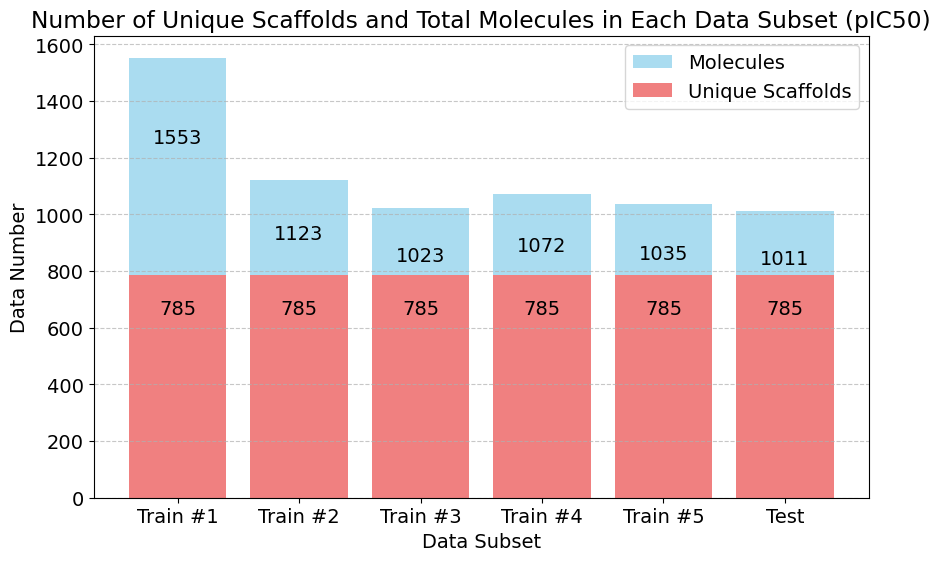

Train #1: 1553
Train #2: 1123
Train #3: 1023
Train #4: 1072
Train #5: 1035
Test: 1011
Data subsets have been saved in /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/pIC50
Failed to read ligand molecule for PDB code 1g42
Failed to read ligand molecule for PDB code 4x6h
Failed to read ligand molecule for PDB code 5a0e
Failed to read ligand molecule for PDB code 5efj
Failed to read ligand molecule for PDB code 6bvh
Failed to read ligand molecule for PDB code 6d3x
Failed to read ligand molecule for PDB code 6d40
Failed to read ligand molecule for PDB code 6d3z
Failed to read ligand molecule for PDB code 6d3y


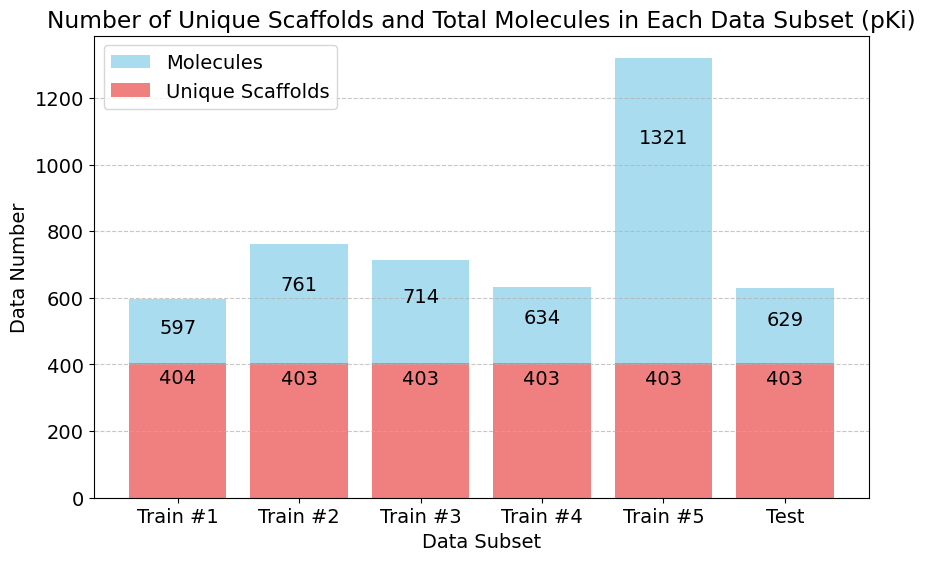

Train #1: 597
Train #2: 761
Train #3: 714
Train #4: 634
Train #5: 1321
Test: 629
Data subsets have been saved in /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/pKi
Failed to read ligand molecule for PDB code 1qng
Failed to read ligand molecule for PDB code 1qnh
Failed to read ligand molecule for PDB code 4aw8
Failed to read ligand molecule for PDB code 4ezr
Failed to read ligand molecule for PDB code 5itf
Failed to read ligand molecule for PDB code 5knj
Failed to read ligand molecule for PDB code 5d2a
Failed to read ligand molecule for PDB code 5iop
Failed to read ligand molecule for PDB code 5f2u
Failed to read ligand molecule for PDB code 5icz
Failed to read ligand molecule for PDB code 5ir1
Failed to read ligand molecule for PDB code 5i2i
Failed to read ligand molecule for PDB code 5ivz
Failed to read ligand molecule for PDB code 5iv2
Failed to read ligand molecule for PDB code 5w6r
Failed to read ligand molecule for PDB code 5n99
Failed to read ligand mol

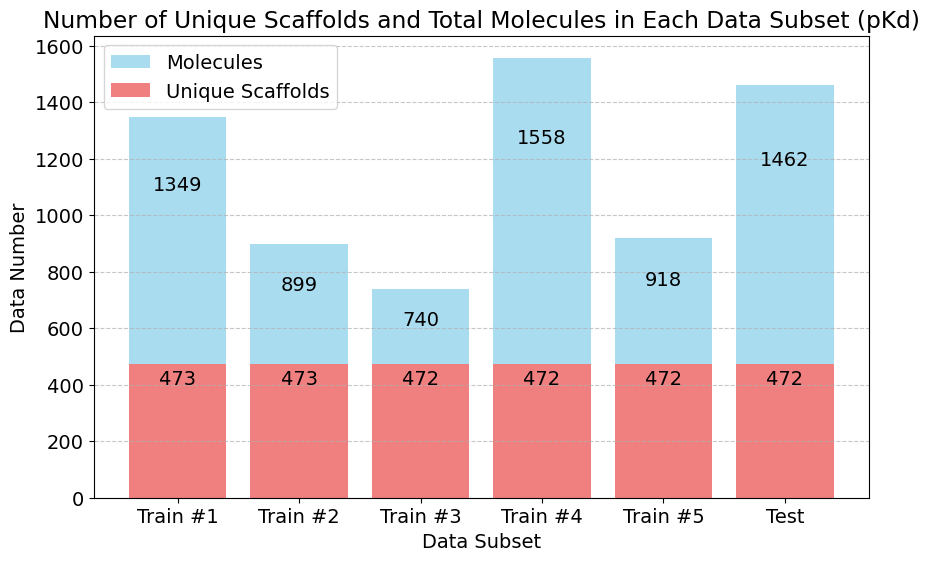

Train #1: 1349
Train #2: 899
Train #3: 740
Train #4: 1558
Train #5: 918
Test: 1462
Data subsets have been saved in /home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/pKd


In [28]:
import pandas as pd
from rdkit import Chem
import pymol
from rdkit.Chem.Scaffolds import MurckoScaffold
import random
import matplotlib.pyplot as plt
import numpy as np
import warnings
import re, os
warnings.filterwarnings('ignore')

# Settings
seed = 1
assay_list = ['pIC50', 'pKi', 'pKd']
data_root = "/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020"

# 设置Matplotlib字体大小
plt.rcParams.update({'font.size': 14})
random.seed(seed)
np.random.seed(seed)

# define a function to add smiles to a df according to PDB code
def add_smiles(df):
    smiles_list = []
    for idx, row in df.iterrows():
        pdb = row['PDB code']
        ligand_path = f'{data_root}/PDBBind_2020_pose_decoys_HL/{pdb}/{pdb}_ligand.mol2'
        if not os.path.exists(ligand_path):
            smiles_list.append(np.nan)
            continue
        ligand_pdb_path = ligand_path.replace('.mol2', '.pdb')
        pymol.cmd.delete('all')
        pymol.cmd.load(ligand_path)
        pymol.cmd.remove('hydrogens')
        # Get the object name of the loaded ligand
        object_list = pymol.cmd.get_object_list()
        if not object_list:  # Skip if no object is loaded
            print(f"No object found for PDB code {pdb}")
            smiles_list.append(np.nan)
            continue
            
        obj_ligand = object_list[0]
        pymol.cmd.save(ligand_pdb_path, obj_ligand)
        
        # Get the ligand molecule as a RDKit molecule
        mol = Chem.MolFromPDBFile(ligand_pdb_path, removeHs=True)
        if mol is None:
            print(f"Failed to read ligand molecule for PDB code {pdb}")
            smiles_list.append(np.nan)
            continue

        # Get the canonical SMILES of the ligand
        smiles = Chem.MolToSmiles(mol)
        smiles_list.append(smiles)

    # Save smiles list to dataframe
    df['SMILES'] = smiles_list
    
    # Drop rows with NaN values in 'SMILES' column
    df = df.dropna(subset=['SMILES'])
    
    # Reset index if needed
    df = df.reset_index(drop=True)

    return df
        
for assay in assay_list:
    # 读取CSV文件
    input_csv = f'/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/data/PDBBind_v2020/{assay}.csv'
    df = pd.read_csv(input_csv)
    df = add_smiles(df)
    
    # Save all smiles
    output_dir = f'{data_root}/{assay}'
    os.makedirs(output_dir, exist_ok = True)
    df.to_csv(f'{output_dir}/all.csv', index=False)

    # 创建一个空字典用于存储分子的Bemis-Murcko scaffolds与子集的映射
    scaffold_to_subset, scaffold_to_index = {}, {}
    
    # Initialize an empty list to store unique scaffolds
    unique_scaffolds = []
    
    # Loop through each row in the DataFrame
    for idx, row in df.iterrows():
        try:
            # Convert the SMILES string to a RDKit molecule object and get its scaffold
            smiles = row['SMILES']
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                scaffold = MurckoScaffold.GetScaffoldForMol(mol)
                # Convert the scaffold to SMILES and append to the unique_scaffolds list
                scaffold_smiles = Chem.MolToSmiles(scaffold)
                unique_scaffolds.append(scaffold_smiles)
        except:
            print(f"Cannot extract scaffold for SMILES: {smiles}")
            # If conversion fails, skip to the next row
            continue
    
    # Get unique scaffold SMILES
    unique_scaffolds = np.unique(unique_scaffolds)

    # 将scaffold类型分配到6个子集中
    num_subsets = 6
    scaffolds_per_subset = len(unique_scaffolds) // num_subsets
    remainder = len(unique_scaffolds) % num_subsets
    
    # 将唯一的scaffold顺序打乱并分配给子集
    random.shuffle(unique_scaffolds)
    
    scaffold_counter = 0
    scaffold_index_counter = 0
    subset_labels = {
        1: 'Train #1',
        2: 'Train #2',
        3: 'Train #3',
        4: 'Train #4',
        5: 'Train #5',
        6: 'Test'
    }
    
    for i in range(1, num_subsets + 1):
        num_scaffolds = scaffolds_per_subset
        if i <= remainder:
            num_scaffolds += 1
        subset_scaffolds = unique_scaffolds[scaffold_counter: scaffold_counter + num_scaffolds]
        scaffold_counter += num_scaffolds
        for scaffold in subset_scaffolds:
            scaffold_to_subset[scaffold] = i
            scaffold_to_index[scaffold] = scaffold_index_counter
            scaffold_index_counter += 1
    
    # 将分子分配到子集中
    df['Subset'] = df['SMILES'].apply(lambda x: subset_labels[scaffold_to_subset.get(Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(Chem.MolFromSmiles(x))), 0)])
    
    # 在此添加Scanfold Index列
    df['Scaffold_Index'] = df['SMILES'].apply(lambda x: scaffold_to_index.get(Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(Chem.MolFromSmiles(x))), 0))
    
    # 在此添加Scaffold_SMILES列
    df['Scaffold_SMILES'] = df['SMILES'].apply(lambda x: Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(Chem.MolFromSmiles(x))))
    
    # 统计每个子集中包含各scaffold索引的数量
    subset_scaffold_counts = df.groupby(['Subset'])['Scaffold_Index'].nunique().reset_index(name='Scaffold_Count')
    
    # 计算每个子集中的总分子数
    subset_total_counts = df.groupby(['Subset']).size().reset_index(name='Total_Count')
    
    # 创建柱状图
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 先获取 "Test" 行的数据
    test_row = subset_total_counts[subset_total_counts['Subset'] == 'Test']
    # 然后从 subset_total_counts 中删除 "Test" 行
    subset_total_counts = subset_total_counts[subset_total_counts['Subset'] != 'Test']
    # 将 "Test" 行添加到 DataFrame 的末尾
    subset_total_counts = pd.concat([subset_total_counts, test_row], ignore_index=True)
    # 先获取 "Test" 行的数据
    test_row = subset_scaffold_counts[subset_scaffold_counts['Subset'] == 'Test']
    # 然后从 subset_total_counts 中删除 "Test" 行
    subset_scaffold_counts = subset_scaffold_counts[subset_scaffold_counts['Subset'] != 'Test']
    # 将 "Test" 行添加到 DataFrame 的末尾
    subset_scaffold_counts = pd.concat([subset_scaffold_counts, test_row], ignore_index=True)
    
    # 左侧y轴，表示每个子集中的唯一scaffold数量
    bar1 = ax.bar(subset_total_counts['Subset'], subset_total_counts['Total_Count'], color='skyblue', alpha=0.7, label='Molecules')
    bar2 = ax.bar(subset_scaffold_counts['Subset'], subset_scaffold_counts['Scaffold_Count'], color='lightcoral', alpha=1, label='Unique Scaffolds')
    ax.set_xlabel('Data Subset')
    ax.set_ylabel('Data Number')
    ax.set_title(f'Number of Unique Scaffolds and Total Molecules in Each Data Subset ({assay})')
    
    # 使用 subset_labels 字典的值作为 x 轴标签
    ax.set_xticks(np.arange(0, num_subsets))  # 增加一个位置以容纳 "Test"
    ax.set_xticklabels([subset_labels[i] for i in range(1, num_subsets + 1)])
    
    # 图例
    legend = ax.legend(loc='best')#, bbox_to_anchor=(1.01, 0.15)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # 标注柱子上的纵坐标值
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, 5.5*height/7),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(bar1)
    autolabel(bar2)
    plt.show()
    
    # 保存分子子集为不同的CSV文件
    os.makedirs(output_dir, exist_ok=True)
    for i in range(1, num_subsets + 1):
        subset_df = df[df['Subset'] == subset_labels[i]]
        
        # 添加Subset列
        subset_df['Subset'] = subset_labels[i]
    
        if i == num_subsets:
            subset_csv = f'{output_dir}/test.csv'
        else:
            subset_csv = f'{output_dir}/train_{i}.csv'
        subset_df.to_csv(subset_csv, index=False) # avoid bad replacement
        print(f"{subset_labels[i]}: {len(subset_df)}")
    
    print(f"Data subsets have been saved in {output_dir}")


### Read model attention attentions

In [1]:
import os, re, json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle, torch

# Read attention weights
result_path = '/home1/yueming/Drug_Discovery/Baselines/GIGN-main/GIGN/model/PDBBind/result1/'
with torch.no_grad():
    # with open(result_path + 'train_attentions.pickle', 'rb') as file:
    #     train_attention_dict = pickle.load(file, encoding='latin1')
    # with open(result_path + 'val_attentions.pickle', 'rb') as file:
    #     val_attention_dict = pickle.load(file, encoding='latin1')
    with open(result_path + 'test_attentions.pickle', 'rb') as file:
        test_attention_dict = pickle.load(file, encoding='latin1')


### View data structure

In [2]:
print(f"Number of test PDB codes: {len(test_attention_dict)}")
# Get an iterator for the dictionary keys
keys_iterator = iter(test_attention_dict.keys())

# Get the first key using next()
first_key = next(keys_iterator)
attention_weight = test_attention_dict[first_key]['attn']
epochs = test_attention_dict[first_key]['epoch']
rmsd = test_attention_dict[first_key]['rmsd']
shift = test_attention_dict[first_key]['shift']
print(f"For PBD code: {first_key}")
print(f"Total epochs: {len(epochs)}, attention_weight: {len(attention_weight)}, rmsd: {len(rmsd)}, shift: {len(shift)}")
print(f"Epoch 1 - attention_weight: {attention_weight[0].sum(0)}")
print(f"Epoch 1 - rmsd: {rmsd[0]}")
print(f"Epoch 1 - shift: {shift[0]}")

Number of test PDB codes: 991
For PBD code: 1htf
Total epochs: 73, attention_weight: 74, rmsd: 74, shift: 74
Epoch 1 - attention_weight: tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0986e-37, 0.0000e+00, 7.2500e+00,
        2.5000e-01, 0.0000e+00, 0.0000e+00, 2.5000e+00], device='cuda:0')
Epoch 1 - rmsd: [2.382, 4.319, 5.217, 5.812, 6.164, 8.579, 8.974, 9.568, 9.73, 10.227]
Epoch 1 - shift: [2, 18, 10, 19, 4, 14, 11, 3, 13, 12]


### Normalize attention weights on all samples (Discard those without rmsd values)

In [3]:
import numpy as np

attention_dict = test_attention_dict.copy()
def normalize_tensor_list(tensor_list, indices_of_not_none):
    normalized_list = []
    global_max_value = 0
    for tensor in tensor_list:
        max_value = torch.max(tensor)
        if max_value > global_max_value:
            global_max_value = max_value
    for tensor in tensor_list:
        # Discard elements based on indices_of_none
        tensor = tensor.mean(0) # average attentions from all shifts
        tensor = tensor[indices_of_not_none]
        # print(f"tensor: {tensor}")
        if len(tensor) > 1:
            # Normalize using global_max_value
            normalized_tensor = tensor / global_max_value
            normalized_list.append(normalized_tensor)
    return normalized_list

# Collate normalized attn vlaues vs rmsds (discard None)
attn_list, rmsd_list = [], []
for key, value in attention_dict.items():
    rmsd = value['rmsd'][0]
    # print(f"rmsd: {rmsd}")
    # Indices of None elements
    indices_of_not_none = [index for index, value in enumerate(rmsd) if value is not None]
    # print(f"indices_of_not_none: {indices_of_not_none}")
    if len(indices_of_not_none) > 1:
        rmsd = [rmsd[i] for i in indices_of_not_none]
        rmsd_list.append(rmsd)
        normalized_attn_list = normalize_tensor_list(value['attn'], indices_of_not_none)
        normalized_attn = torch.stack(normalized_attn_list)#[-1]#[len(epochs)-100]# average on epochs
        print(f"attn ({normalized_attn.shape}, sum: {sum(normalized_attn[-1])}): {normalized_attn[-1]}")
        print(f"rmsd: {rmsd}")
        attention_dict[key]['attn_normalized'] = normalized_attn # (epochs, shifts)
        attn_list.append(normalized_attn.detach().cpu().numpy())

print(f"attn_list: {len(attn_list)}, rmsd_list: {len(rmsd_list)}")

attn (torch.Size([74, 10]), sum: 1.3333333730697632): tensor([0.4000, 0.0000, 0.1331, 0.0000, 0.0000, 0.0000, 0.2002, 0.3333, 0.2667,
        0.0000], device='cuda:0')
rmsd: [2.382, 4.319, 5.217, 5.812, 6.164, 8.579, 8.974, 9.568, 9.73, 10.227]
attn (torch.Size([74, 10]), sum: 1.0): tensor([1.7500e-01, 1.2500e-01, 0.0000e+00, 1.2500e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.5001e-01, 1.2500e-01, 3.7354e-26], device='cuda:0')
rmsd: [2.932, 3.682, 3.969, 5.101, 5.329, 5.598, 5.791, 5.845, 6.417, 7.095]
attn (torch.Size([74, 10]), sum: 1.3333332538604736): tensor([0.2938, 0.5333, 0.0000, 0.1197, 0.0396, 0.0000, 0.0470, 0.0000, 0.3000,
        0.0000], device='cuda:0')
rmsd: [4.313, 7.06, 7.441, 7.934, 7.941, 7.963, 8.045, 8.623, 9.269, 10.363]
attn (torch.Size([74, 9]), sum: 1.3333332538604736): tensor([3.4298e-40, 5.5556e-01, 0.0000e+00, 3.3333e-01, 3.7037e-02, 4.0741e-01,
        0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0')
rmsd: [2.792, 3.19, 3.634, 4.164, 5.039, 5.81

### Collate normalized attn vlaues vs rmsds (discard None)

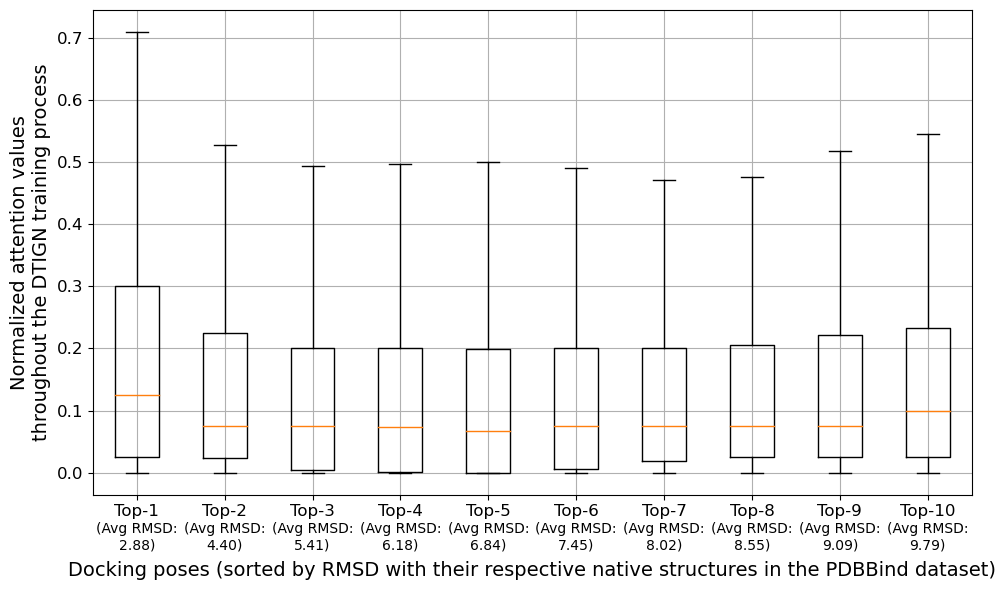

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Sort rmsd according to attn values
sorted_attn_list_by_rmsd, sorted_rmsd_list, warm_up_epochs = [], [], 40
for i, rmsd in enumerate(rmsd_list):
    # Sort the array in ascending order and return the indices of the sorted elements
    sorted_rmsd_indices = np.argsort(rmsd)
    sorted_rmsd = [rmsd[i] for i in sorted_rmsd_indices]
    sorted_rmsd_list.append(sorted_rmsd)
    attn = attn_list[i]
    # print(attn, sorted_attn_indices_descending, rmsd)
    sorted_attn = [attn[:, i] for i in sorted_rmsd_indices]
    sorted_attn_list_by_rmsd.append(sorted_attn)
# print(sorted_rmsd_list)
# Create directory if it doesn't exist
save_dir = "./figures/PDBBind/"
os.makedirs(save_dir, exist_ok=True)

# Top list
top_list = [1, 2, 3, 4, 5, 6, 7, 8 , 9, 10]

# Initialize lists for box plot
box_data, avg_rmsd = [], []

# Calculate top RMSD values for each top
for i, top in enumerate(top_list):
    top_attn, avg_rmsd_per_top = [], []
    for j, sorted_attn in enumerate(sorted_attn_list_by_rmsd): # for all pdbs
        if top <= len(sorted_attn):
            top_sorted_attn = sorted_attn[top-1]
            top_sorted_attn_non_zero = top_sorted_attn[top_sorted_attn != 0]
            top_attn.append(top_sorted_attn_non_zero)
            top_sorted_rmsd = sorted_rmsd_list[j][top-1]
            avg_rmsd_per_top.append(top_sorted_rmsd)
    avg_rmsd_per_top = np.mean(avg_rmsd_per_top)
    avg_rmsd.append(avg_rmsd_per_top)
    top_attn = np.concatenate(top_attn)
    box_data.append(top_attn)

# Create box-whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(box_data, labels=[f'Top-{top}' for top in top_list], showfliers=False)  # Customizing x-axis tick labels
plt.xlabel('Docking poses (sorted by RMSD with their respective native structures in the PDBBind dataset)', fontsize=14, labelpad=30)  # Enlarge font size
plt.ylabel('Normalized attention values\nthroughout the DTIGN training process', fontsize=14)  # Enlarge font size
plt.xticks(fontsize=12)  # Enlarge x-axis tick font size
plt.yticks(fontsize=12)  # Enlarge y-axis tick font size
plt.grid(True)

# Add average RMSD below x ticks
for i, avg in enumerate(avg_rmsd):
    plt.text(i + 1, -0.08, f'(Avg RMSD:\n{avg:.2f})', fontsize=10, ha='center', va='top')

plt.subplots_adjust(left=0.25)  # Adjusting left margin
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(save_dir, 'top_attend_rmsd_pIC50.png'))

# Show the plot
plt.show()
